In [36]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy as scp
from scipy import interpolate
from scipy.linalg import null_space

In [37]:
dx = 0.2
#interior points
x,z = np.meshgrid(np.arange(0,2+dx,dx),np.arange(0,1+dx,dx))
n = x.shape[0]
m = x.shape[1]

ni = n-2
mi = m-2
xi = x[1:-1,1:-1].reshape((ni*mi,1))
zi = z[1:-1,1:-1].reshape((ni*mi,1))



xo = np.zeros((n*2 + 2*(m-2),1))
zo = np.zeros((n*2 + 2*(m-2),1))
xo[0:n,0] = x[:,0]
zo[0:n,0] = z[:,0]

xo[n:2*n,0] = x[:,-1]
zo[n:2*n,0] = z[:,-1]

xo[2*n:2*n+m-2,0] = x[0,1:-1]
zo[2*n:2*n+m-2,0] = z[0,1:-1]
xo[2*n+m-2:,0] = x[-1,1:-1]
zo[2*n+m-2:,0] = z[-1,1:-1]



In [38]:
#ordering boundary points
xo = np.zeros((n*2 + 2*(m-2),1))
zo = np.zeros((n*2 + 2*(m-2),1))
xo[0:n,0] = x[:,0]
zo[0:n,0] = z[:,0]
xo[n:n+m-2,0] = x[-1,1:-1]
zo[n:n+m-2,0] = z[-1,1:-1]
xo[n+m-2:2*n+m-2,0] = np.flipud(x[:,-1])
zo[n+m-2:2*n+m-2,0] = np.flipud(z[:,-1])
xo[2*n+m-2:,0] = np.flipud(x[0,1:-1])
zo[2*n+m-2:,0] = np.flipud(z[0,1:-1])

#print(xo)

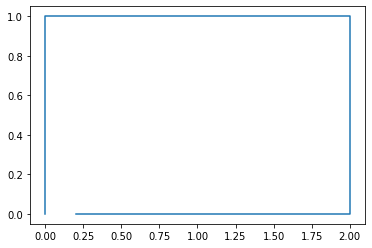

In [39]:
X = np.concatenate((xi,xo)) -1
Z = np.concatenate((zi,zo)) -1
plt.plot(xo,zo)

In [40]:
#converting into circle coordinates
#Xc = X #0.5*np.sin(X) #+X*np.sqrt(1-Z**2/2) 
#Zc = Z +np.sin(Xc*5)*0.2#Z*np.sqrt(1-X**2/2) 
Xc = X*np.sqrt(1-Z**2/2) 
Zc = Z*np.sqrt(1-X**2/2)  #+ 0.2*np.sin(2*X)*(1+Z)**2

xoc = Xc[ni*mi:,:]
zoc = Zc[ni*mi:,:]

#calculating boundary normals
xoc_normal = xoc*0
zoc_normal = zoc*0
xoc_normal[1:-1,0] = -zoc[2:,0]+zoc[0:-2,0]
zoc_normal[1:-1,0] = xoc[2:,0]-xoc[0:-2,0]

#boundary points
zoc_normal[0,0] = xoc[1,0] - xoc[-1,0]
xoc_normal[0,0] = -zoc[1,0] + zoc[-1,0]
zoc_normal[-1,0] = xoc[0,0] - xoc[-2,0]
xoc_normal[-1,0] = -zoc[0,0] + zoc[-2,0]


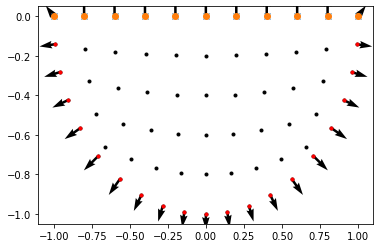

In [41]:
plt.plot(Xc,Zc,'.', color = 'k')
plt.plot(xoc,zoc,'.', color = 'r')
plt.plot(xoc[n-1:n+m-1],zoc[n-1:n+m-1],'x')
plt.plot(Xc[mi*ni + n-1:mi*ni+n+m-1],Zc[mi*ni + n-1:mi*ni+n+m-1],'o')
#plt.gca().set_aspect('equal', adjustable='box')
plt.quiver(xoc,zoc,xoc_normal,zoc_normal)

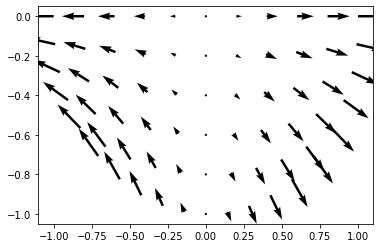

In [42]:
#building velocity field 
pi = 3.14159
#u_test = -np.cos(pi*Xc/2)*Zc
#v_test = pi*np.sin(pi*Xc/2)*(1-Zc**2)/4
u_test = Xc*0 + 1
v_test = Xc*0
u_test = np.cos(pi*Xc/2)
#u_test = Xc
v_test = Zc*np.sin(pi*Xc/2)*pi/2
plt.quiver(Xc,Zc,u_test,v_test)


In [43]:
def phi(x_i,z_i,x_j,z_j,a):
    eps = 1e-6
    r = np.sqrt((x_i-x_j)**2 + (z_i-z_j)**2)
    
    return np.exp(-(a*r)**2)

In [44]:
def nabla2(xi,zi,xj,zj,a):
    eps = 1e-6
    return 4*a**2*(a**2*(xi - xj)**2 + a**2*(zi - zj)**2 - 1)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

In [45]:
def dphidx(xi,zi,xj,zj,a):
    return 2*a**2*(-xi + xj)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

In [46]:
def dphidz(xi,zi,xj,zj,a):
    return 2*a**2*(-zi + zj)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

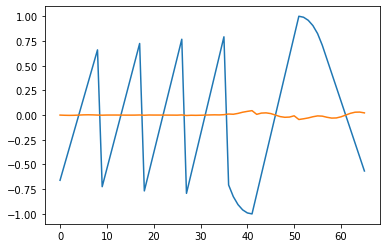

In [47]:
#calculating features of u and v fields

#converting to galerkin representation:
a = 1/(5*dx)
phi_u = np.zeros((n*m,n*m))
nabla2_phi_u = np.zeros((n*m,n*m))
dphi_u_dx = np.zeros((n*m,n*m))
dphi_u_dz = np.zeros((n*m,n*m))
for i in range(0,n*m):
    for j in range(0,n*m):
        phi_u[i,j] = phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        nabla2_phi_u[i,j] = nabla2(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        dphi_u_dx[i,j] = dphidx(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        dphi_u_dz[i,j] = dphidz(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)


u_j = np.linalg.solve(phi_u,u_test)
v_j = np.linalg.solve(phi_u,v_test)

nabla2_u = np.matmul(nabla2_phi_u,u_j)
nabla2_v = np.matmul(nabla2_phi_u,v_j)
dudx = np.matmul(dphi_u_dx,u_j)
dudz = np.matmul(dphi_u_dz,u_j)
dvdx = np.matmul(dphi_u_dx,v_j)
dvdz = np.matmul(dphi_u_dz,v_j)

#plt.quiver(Xc,Zc,dudx,dudz*0)
#print(dudx+dvdz)
plt.plot(u_test)
plt.plot(nabla2_u)



vector of Galerkin coefficients given as:
$q = [\mu_{interior}, \mu_{exterior}, p_{interior}, p_{exterior}]^T$

In [48]:
gov_mat = np.zeros((2*n*m, 2*n*m))
nabla2u = Xc*0 + 1

#setting up solution matrix:

#horizontal momentum
for i in range(0,m*n):
    for j in range(0,m*n):
        gov_mat[i,j] = nabla2_u[i,0]*phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        gov_mat[i,j+m*n] = dphidx(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0] ,a)

#vertical momentum 
nabla2v = Xc*0 + 1
for i in range(0,m*n):
    for j in range(0,m*n):
        gov_mat[i+m*n,j] = nabla2_v[i,0]*phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        gov_mat[i+m*n,j+m*n] = dphidz(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0] ,a)


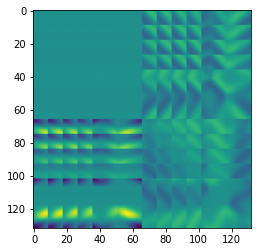

In [49]:
plt.imshow(gov_mat)

In [50]:
#dealing with boundary conditions:
#free surface boundary is located between points Xc[mi*ni + n-1:mi*ni+n+m-1]

#viscosity boundary condition
for i in range(mi*ni + n-1,mi*ni+n+m-1):
    for j in range(0,m*n):
        
        gov_mat[i,j] = dphidz(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)

#pressure boundary condition
for i in range(mi*ni + n-1,mi*ni+n+m-1):
    for j in range(0,m*n):
        
        gov_mat[i+m*n,j+m*n] = phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        

In [51]:
test = null_space(gov_mat)
print(test)

[[ 2.23052566e-02  8.41650011e-04  9.58956875e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.22850212e-02 -4.38002508e-02 -2.30035051e-02 ...  1.74241199e-03
   1.43428129e-02 -2.69621702e-02]
 [ 6.96970101e-03  8.91450018e-02  3.41366211e-02 ... -9.15128810e-03
  -4.33648917e-02  6.73970785e-02]
 ...
 [-1.21211817e-01 -5.05321235e-02  3.18549215e-01 ...  3.18181717e-03
   8.61363190e-04 -1.52180656e-02]
 [ 9.02361188e-02  2.99666841e-02 -1.91420239e-01 ... -1.50416094e-03
  -3.28546137e-04  6.34667643e-03]
 [-4.31646199e-02 -1.54353430e-02  9.48019070e-02 ...  5.15694749e-04
   3.51016441e-05 -1.30862533e-03]]


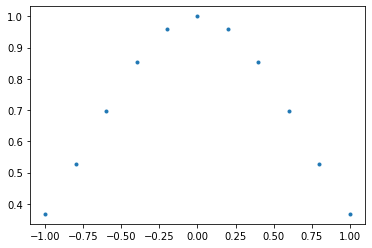

In [52]:
xi = np.arange(-1,1+dx,dx)

plt.plot(xi,np.exp(-a**2*xi**2),'.')
